In [97]:
import os
from os.path import expanduser
import socket
import sys
import glob

# BELOW IS SYSTEM/PATH CONFIGURATION #
my_home = expanduser("~")
running_system = socket.gethostname()
# Configure machine's names here #
systemHLRN = 'blogin1'
systemLOCAL = 'Laurents-MacBook-Pro.local'
my_home = expanduser("~")
# Define local pass #
wd_path = '/home/hbkoziel/pyfesom/'
save_path = wd_path+'/figures/Arc12/FINAL/'

#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')
#########################################

In [2]:
import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

import xarray as xr
import pandas as pd

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

No joblib
no cmocean


In [3]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/home/hbkoziel/pyfesom/data/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'LIM'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'

/home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh


In [4]:
dates = pd.date_range('1985', freq="M", periods= 12*len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = dates
#data.time.data = dates

In [5]:
data

<xarray.Dataset>
Dimensions:            (nod2d: 753179, time: 372)
Coordinates:
  * time               (time) datetime64[ns] 1985-01-31 ... 2015-12-31
Dimensions without coordinates: nod2d
Data variables:
    Felimphy           (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Felimdia           (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Nlimphy            (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Nlimdia            (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Silim              (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Phy_Light_limiter  (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Dia_Light_limiter  (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
Attributes:
    description:  Photosynthesis Limiting factors
    history:      Created 

In [7]:
data_np = data.Nlimphy.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_np = data_np.compute()

data_nd = data.Nlimdia.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_nd = data_nd.compute()

data_si = data.Silim.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_si = data_si.compute()

data_lp = data.Phy_Light_limiter.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_lp = data_lp.compute()

data_ld = data.Dia_Light_limiter.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_ld = data_ld.compute()

In [8]:
ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
f           = Dataset(ncfile, 'r')
NodalAreaModel = f.variables['cluster_area'][:]

In [26]:
print('loading index...')
df = pd.read_csv('/home/hbkoziel/awi-models/data/mesh/meshArc4.5/bioregion_index_latlon.csv', delimiter=',',header=0)
print('LOADING DONE')
df.sort_values(by ='Unique_ID',inplace=True)
index = df["Unique_ID"]
index_unique = df.Unique_ID.unique().tolist()
index_unique.pop(-1)
print('SORTING...')
names = df.Name.unique().tolist()
names.pop(-1)
names[3]='Beaufort Sea - shelf'
names[4]='Amundsen-Viscount'
names.append('All Arctic Ocean (>66N)')
print('DONE')

loading index...
LOADING DONE
SORTING...
DONE


In [163]:
dates = pd.date_range('1985', freq="MS", periods= 12*len(np.arange(1985,2016,1)))
ind_bio = df.full_index[df.Unique_ID == 24]
df2 = pd.DataFrame()
df3 = pd.DataFrame()

area_bio_np = np.zeros(len(data_np.time))
area_bio_nd = np.zeros(len(data_np.time))
area_bio_si = np.zeros(len(data_np.time))
area_bio_lp = np.zeros(len(data_np.time))
area_bio_ld = np.zeros(len(data_np.time))
area_bio_light = np.zeros(len(data_np.time))
area_bio_nut = np.zeros(len(data_np.time))

for i in range(0,len(data_np.time)):

    ind_np = np.intersect1d(np.where(data_np[i,:] <.5),ind_bio)
    ind_nd = np.intersect1d(np.where(data_nd[i,:] <.5),ind_bio)
    ind_si = np.intersect1d(np.where(data_si[i,:] <.5),ind_bio)
    ind_lp = np.intersect1d(np.where(data_lp[i,:] <.5),ind_bio)
    ind_ld = np.intersect1d(np.where(data_ld[i,:] <.5),ind_bio)
    ind_nut = np.intersect1d(ind_np, ind_nd)
    ind_nut = np.intersect1d(ind_nut,ind_si)
    ind_light = np.intersect1d(ind_lp, ind_ld)
    
    area_bio_np[i] = np.sum(NodalAreaModel[ind_np])
    area_bio_nd[i] = np.sum(NodalAreaModel[ind_nd])
    area_bio_si[i] = np.sum(NodalAreaModel[ind_si])
    area_bio_lp[i] = np.sum(NodalAreaModel[ind_lp])
    area_bio_ld[i] = np.sum(NodalAreaModel[ind_ld])
    area_bio_nut[i] = np.sum(NodalAreaModel[ind_nut])
    area_bio_light[i] = np.sum(NodalAreaModel[ind_light])
    
df2 = pd.DataFrame()
df2['time'] = dates
df2.set_index('time', inplace= True)
df2['area_np'] = area_bio_np
df2['area_nd'] = area_bio_nd
df2['area_si'] = area_bio_si
df2['area_lp'] = area_bio_lp
df2['area_ld'] = area_bio_ld
df2['light'] = area_bio_light
df2['nutrient'] = area_bio_nut

df3_yearly_em = df2.resample('Y').sum()

In [164]:
dates = pd.date_range('1985', freq="MS", periods= 12*len(np.arange(1985,2016,1)))
ind_bio = df.full_index[df.Unique_ID == 25]
df2 = pd.DataFrame()
df3 = pd.DataFrame()

area_bio_np = np.zeros(len(data_np.time))
area_bio_nd = np.zeros(len(data_np.time))
area_bio_si = np.zeros(len(data_np.time))
area_bio_lp = np.zeros(len(data_np.time))
area_bio_ld = np.zeros(len(data_np.time))
area_bio_light = np.zeros(len(data_np.time))
area_bio_nut = np.zeros(len(data_np.time))

for i in range(0,len(data_np.time)):

    ind_np = np.intersect1d(np.where(data_np[i,:] <.5),ind_bio)
    ind_nd = np.intersect1d(np.where(data_nd[i,:] <.5),ind_bio)
    ind_si = np.intersect1d(np.where(data_si[i,:] <.5),ind_bio)
    ind_lp = np.intersect1d(np.where(data_lp[i,:] <.5),ind_bio)
    ind_ld = np.intersect1d(np.where(data_ld[i,:] <.5),ind_bio)
    ind_nut = np.intersect1d(ind_np, ind_nd)
    ind_nut = np.intersect1d(ind_nut,ind_si)
    ind_light = np.intersect1d(ind_lp, ind_ld)
    
    area_bio_np[i] = np.sum(NodalAreaModel[ind_np])
    area_bio_nd[i] = np.sum(NodalAreaModel[ind_nd])
    area_bio_si[i] = np.sum(NodalAreaModel[ind_si])
    area_bio_lp[i] = np.sum(NodalAreaModel[ind_lp])
    area_bio_ld[i] = np.sum(NodalAreaModel[ind_ld])
    area_bio_nut[i] = np.sum(NodalAreaModel[ind_nut])
    area_bio_light[i] = np.sum(NodalAreaModel[ind_light])
    
df2 = pd.DataFrame()
df2['time'] = dates
df2.set_index('time', inplace= True)
df2['area_np'] = area_bio_np
df2['area_nd'] = area_bio_nd
df2['area_si'] = area_bio_si
df2['area_lp'] = area_bio_lp
df2['area_ld'] = area_bio_ld
df2['light'] = area_bio_light
df2['nutrient'] = area_bio_nut

df3_yearly_am = df2.resample('Y').sum()

# Description

The area below represent the sum of monthly maps representing areas limited or co-limited by either nutrients (DIN and/or DSi) or light

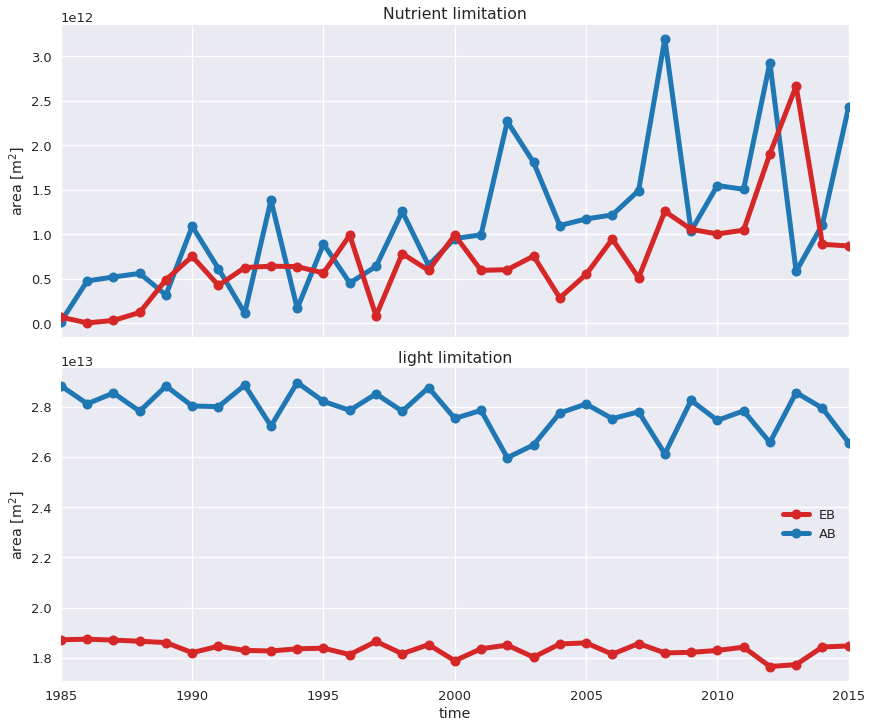

In [169]:
figsize = (12, 10)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, constrained_layout=True, sharex=True)

plt.style.use('seaborn')
plt.style.use('seaborn-talk')

df3_yearly_em['nutrient'].plot(kind = 'line',style='.-',markersize = 20, lw = 5, ax = ax1, legend = False, color = 'tab:red', zorder = 2)
df3_yearly_am['nutrient'].plot(kind = 'line',style='.-',markersize = 20, lw = 5, ax = ax1, legend = False, color = 'tab:blue', zorder = 1)
ax1.set_ylabel('area [m$^{2}$]')
ax1.set_title('Nutrient limitation')

df3_yearly_em['light'].plot(kind = 'line',style='.-',markersize = 20, lw = 5, ax = ax2, legend = False, color = 'tab:red', zorder = 2, label = 'EB')
df3_yearly_am['light'].plot(kind = 'line',style='.-',markersize = 20, lw = 5, ax = ax2, legend = False, color = 'tab:blue', zorder = 1, label = 'AB')
ax2.set_ylabel('area [m$^{2}$]')
ax2.set_title('light limitation')

plt.legend()

plt.savefig(save_path+'FIG3.png', dpi = 300, bbox_inches='tight') 